# Planification de la production d'électricité

Dans ce projet d'optimisation linéaire, réalisé par Nikolaos Papastefanikis et Valentin Lassaigne, nous avons construit, pas à pas, un modèle d'optimisation et étudié les conséquences des nouvelles contraintes sur le système.
Nous avons choisi, pour chaque question du projet de présenter :
* les nouvelles données et variables introduites dans le modèle
* le nouveau modèle mathématique utilisé pour représenter le problème
* le code python avec les nouvelles lignes et leur commentaire
* Un graphique avec une présentation des résultats

## 1. Modèle de base des centrales thermiques

### 1.1 Planification journalière du parc thermique

In [3]:
import gurobipy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Données du problème :<br>
•	Dem<sub>j</sub> : Demande défini sur 24 périodes<br>
•	nb<sub>i</sub> : le nombre maximum de centrale disponible pour chaque type i de centrale<br>
•	Pmin<sub>i</sub> : Puissance minimum autorisé pour chaque type i de centrale<br>
•	Pmax<sub>i</sub> : Puissance maximum autorisé pour chaque type i de centrale<br>
•	Cmwh<sub>i</sub> : Coût de fonctionnement pour chaque type i de centrale<br>

Variables :<br>
•	NBcentrale<sub>i,j</sub> : Nombre de centrale de type i utilisé à la période j<br>
•	Puiss<sub>i,j</sub> : Puissance délivré par les centrales de type i à la période j<br>


Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} Puiss_{i,j} * Cmwh_{i}$$

S.T : 

$$
\left.
    \begin{array}{lcr}
1.   & NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\} \\
2.   & \sum \limits _{i=1} ^{3} Puiss_{i,j} = Dem_{j} & \forall j \in \{1,..,24\}\\
3.   & 0 \le NBcentrale_{i,j}\le nb_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & Puiss_{i,j} \in \mathbb{R} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & NBcentrale_{i,j} \in \mathbb{N} &  \forall i \in \{1,2,3\} , \forall j \in \{1,..,24\}\\
    \end{array}
\right.
$$

In [18]:
#Demande sur 24 période
Dem=[15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]
for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3

#Dictionnaire pour la gestion des données par type de centrale
CENTRALE, nb, Pmin, Pmax, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 1.5],
    'B' : [10, 1250, 1750, 1.38],
    'C' : [5, 1500, 4000, 2.750],
})

Model = gp.Model(name = 'Centrales thermiques')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

#Contrainte de capacité minimum pour les centrales
CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

#Contrainte de capacité maximum pour les centrales
CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

#Contrainte de respect de la demande
CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

#Contrainte sur le nombre maximum de centrale disponible
CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

Model.setObjective(sum(Puiss[i,j]*Cmwh[i] for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 240 rows, 144 columns and 432 nonzeros
Model fingerprint: 0xbaa479b0
Variable types: 72 continuous, 72 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 3e+00]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 4e+04]
Found heuristic solution: objective 1234360.0000
Presolve removed 234 rows and 139 columns
Presolve time: 0.01s
Presolved: 6 rows, 5 columns, 14 nonzeros
Found heuristic solution: objective 869400.00000
Variable types: 2 continuous, 3 integer (0 binary)

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 4 (of 4 available processors)

Solution count 2: 869400 1.23436e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.694000000000e+05, best bound 8.694000000000e+05, gap 0.0000%


In [39]:
def Graph_puiss():
    PA=[]; PB=[]; PC=[]; PTOT=[]
    for j in range(24):        
        PA.append(Puiss["A",j].x)
        PB.append(Puiss["B",j].x)
        PC.append(Puiss["C",j].x)
        #PTOT.append(Puiss["A",j].x + Puiss["B",j].x + Puiss["C",j].x)

    ar = [PA, PB, PC, PTOT]
    df=pd.DataFrame(data=ar, index=["A", "B", "C", "TOT"])
    plt.plot(df.loc["A"],'r', label="Centrale A")
    plt.plot(df.loc["B"],'b', label='Centrale B')
    plt.plot(df.loc["C"],'g', label='Centrale C')
    plt.plot(Dem,'grey', label="Demande")
    #plt.plot(df.loc["TOT"],'pink', label='Total')
    plt.title('Puissance délivrée par type de centrale et par période')
    plt.legend()
    plt.show()
    print("Coûts d'opération :" ,round(Model.objVal, 2), "€")
    

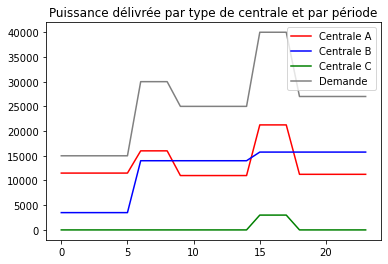

Coûts d'opération : 1015150.0 €


In [40]:
Graph_puiss()

*Résultats* :<br>
Sur ce graphique, nous pouvons remarquer que les centrales de types "C" ne sont jamais appelées. C'est le principe du "merit order", les centrales les moins coûteuses sont appelées en premier. Les centrales suivantes sont ensuites appelées, ou non, en fonction de la demande et des capacités.

## 2. Coûts d'opération

### 2.1 coûts de fonctionnement

Nouvelles données du problème :<br>
•	Cbase<sub>i</sub> : Coût de fonctionnement à la puissance minimale pour chaque type i de centrale<br>
•	Cmwh<sub>i</sub> : Coût supplémentaire de fonctionnement au-dessus de la  puissance minimale pour chaque type i de centrale<br>

Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i}$$

S.T : 

$$
\left.
    \begin{array}{lcr}
1.   & NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\} \\
2.   & \sum \limits _{i=1} ^{3} Puiss_{i,j} = Dem_{j} & \forall j \in \{1,..,24\}\\
3.   & 0 \le NBcentrale_{i,j}\le nb_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & Puiss_{i,j} \in \mathbb{R} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & NBcentrale_{i,j} \in \mathbb{N} &  \forall i \in \{1,2,3\} , \forall j \in \{1,..,24\}\\
    \end{array}
\right.
$$




In [21]:
#Modification du dictionnaire pour prendre en compte les nouvelles données
CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

Dem=[15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]
for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

#Calcul du nouveau coup de fonctionnement des centrales thermiques
Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
            for i in CENTRALE for j in range(len(Dem))}

Model.setObjective(sum(Cnew[i,j] for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

Model.update()
Model.optimize()              

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 240 rows, 144 columns and 432 nonzeros
Model fingerprint: 0x380c2505
Variable types: 72 continuous, 72 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 4e+04]
Found heuristic solution: objective 1254000.0000
Presolve removed 234 rows and 139 columns
Presolve time: 0.02s
Presolved: 6 rows, 5 columns, 14 nonzeros
Found heuristic solution: objective 978900.00000
Variable types: 2 continuous, 3 integer (0 binary)

Root relaxation: objective 9.787500e+05, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0      978900.000 978900.000  0.00%     -    

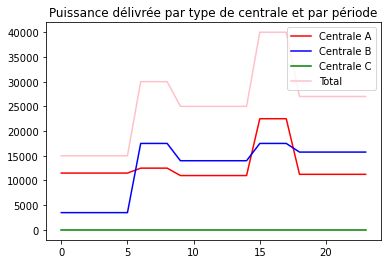

Coûts d'opération : 978900.0 €


In [22]:
Graph_puiss()

*Résultats* :<br>
Nous avons changé la méthode de calcul du coût de fonctionnement mais le principe du "merit order" s'applique toujours et les centrales de type "C" ne sont pas appelées. On remarque que les centrales de type "A" deviennent moins coûteuses que les centrales de type "B". Elles sont donc utilisées au maximum de leur capacité.

### 2.2 coûts de démarrage

Nouvelle donnée du problème :<br>
•   Cstart<sub>j</sub> : Coût de démarrage pour chaque type i de centrale <br>

Nouvelle variable :<br>
•   NBstart<sub>i,j</sub> : Nombre de centrale de type i qui ont été allumé à la période j


Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i} + NBstart_{i,j} * Cstart_{i} $$

S.T : 

$$
\left.
    \begin{array}{lcr}
1.   & NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\} \\
2.   & \sum \limits _{i=1} ^{3} Puiss_{i,j} = Dem_{j} & \forall j \in \{1,..,24\}\\
3.   & 0 \le NBcentrale_{i,j}\le nb_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
4.   & NBcentrale_{i,j} - NBcentrale_{i,j-1} \le NBstart_{i,j} &  \forall i \in \{1,2,3\}, \forall j \in \{2,..,24\}\\
5.   & NBcentrale_{i,0} \le NBstart_{i,0}  &  \forall i \in \{1,2,3\}\\
     & NBstart_{i,j} \ge 0 &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & Puiss_{i,j} \in \mathbb{R} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & NBcentrale_{i,j}, NBstart_{i,j} \in \mathbb{N} &  \forall i \in \{1,2,3\} , \forall j \in \{1,..,24\}\\
    \end{array}
\right.
$$


In [34]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})


Dem=[15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]
for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

#Intégration de la nouvelle variable au modèle
NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

#Contrainte pour le calcul du nombre de centrale de type i à allumer à la période j
CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

#Initialisation de la variable NBstart pour la 1ère période
CSTR6 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0])
         for i in CENTRALE}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
            for i in CENTRALE for j in range(len(Dem))}

#Ajout du coût de démarrage dans l'objectif
Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [35]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 312 rows, 216 columns and 645 nonzeros
Model fingerprint: 0xb583e011
Variable types: 72 continuous, 144 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 4e+04]
Found heuristic solution: objective 1489500.0000
Presolve removed 108 rows and 30 columns
Presolve time: 0.00s
Presolved: 204 rows, 186 columns, 522 nonzeros
Variable types: 42 continuous, 144 integer (0 binary)
Found heuristic solution: objective 1412055.0000

Root relaxation: objective 1.011257e+06, 58 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1011257.14    0   26 1412055.00 1011257.14  28.4% 

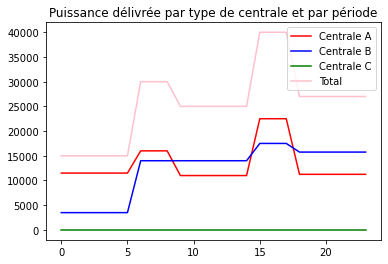

Coûts d'opération : 1014400.0 €


In [36]:
Graph_puiss()

*Résultats* :<br>
Nous avons ajouté un coût de démarrage au modèle. Malgré un faible coût de démarrage pour les centrales de type "c", elles ne sont toujours pas appelées car leur coût de fonctionnement reste bien supérieur au deux autres.

## 3. Réserve de puissance

### 3.1 Réserve

Nouvelle donnée du problème :<br>
•   Réserve : Les centrales doivent être capable de produire 15% en plus par mesure de précaution <br>

Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i} + NBstart_{i,j} * Cstart_{i} $$

S.T : 

$$
\left.
    \begin{array}{lcr}
1.   & NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\} \\
2.   & \sum \limits _{i=1} ^{3} Puiss_{i,j} = Dem_{j} & \forall j \in \{1,..,24\}\\
3.   & 0 \le NBcentrale_{i,j}\le nb_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
4.   & NBcentrale_{i,j} - NBcentrale_{i,j-1} \le NBstart_{i,j} &  \forall i \in \{1,2,3\}, \forall j \in \{2,..,24\}\\
5.   & NBcentrale_{i,0} \le NBstart_{i,0}  &  \forall i \in \{1,2,3\}\\
6.   & \sum \limits_{i=1}^{3} NBcentrale_{i,j} * Pmax_{i}\ge Dem_{j} * Reserve  &  \forall j \in \{1,..,24\}\\
     & NBstart_{i,j} \ge 0 &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & Puiss_{i,j} \in \mathbb{R} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & NBcentrale_{i,j}, NBstart_{i,j} \in \mathbb{N} &  \forall i \in \{1,2,3\} , \forall j \in \{1,..,24\}\\
    \end{array}
\right.
$$


In [37]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})


Dem=[15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]
for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR6 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0])
         for i in CENTRALE}

#Calcul de la puissance délivrable potentielle
POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) 
       for j in range(len(Dem))}

#La puissance potentielle doit être supérieure à la demande plus la réserve
CSTR_31 =  { (j) : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
            for i in CENTRALE for j in range(len(Dem))}

Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [38]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 336 rows, 216 columns and 717 nonzeros
Model fingerprint: 0x15b20e33
Variable types: 72 continuous, 144 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 5e+04]
Found heuristic solution: objective 1338010.0000
Presolve removed 108 rows and 30 columns
Presolve time: 0.00s
Presolved: 228 rows, 186 columns, 594 nonzeros
Found heuristic solution: objective 1291030.0000
Variable types: 42 continuous, 144 integer (0 binary)
Found heuristic solution: objective 1257225.0000

Root relaxation: objective 1.012257e+06, 67 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1

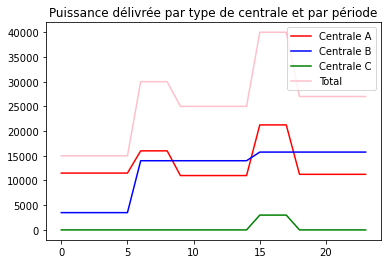

Coûts d'opération : 1015150.0 €


In [29]:
Graph_puiss()

*Résultats* :<br>
Ici, nous avons rajouté une règle de réserve de 15% de la demande pour anticiper une potentielle hausse de celle-ci. On remarque qu'une centrale de type "c" est appelée pendant le pique de la journée afin d'assurer cette réserve.

## 4 Planification cyclique

### 4.1 horizon journalier cyclique

Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i} + NBstart_{i,j} * Cstart_{i} $$

S.T : 

$$
\left.
    \begin{array}{lcr}
1.   & NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\} \\
2.   & \sum \limits _{i=1} ^{3} Puiss_{i,j} = Dem_{j} & \forall j \in \{1,..,24\}\\
3.   & 0 \le NBcentrale_{i,j}\le nb_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
4.   & NBcentrale_{i,j} - NBcentrale_{i,j-1} \le NBstart_{i,j} &  \forall i \in \{1,2,3\}, \forall j \in \{2,..,24\}\\
5.   & NBcentrale_{i,0} - NBcentrale_{i,24}\le NBstart_{i,0}  &  \forall i \in \{1,2,3\}\\
6.   & \sum \limits_{i=1}^{3} NBcentrale_{i,j} * Pmax_{i}\ge Dem_{j} * Reserve  &  \forall j \in \{1,..,24\}\\
     & NBstart_{i,j} \ge 0 &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & Puiss_{i,j} \in \mathbb{R} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & NBcentrale_{i,j}, NBstart_{i,j} \in \mathbb{N} &  \forall i \in \{1,2,3\} , \forall j \in \{1,..,24\}\\
    \end{array}
\right.
$$

In [30]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})


Dem = [15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) 
       for j in range(len(Dem))}

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE),"=",Dem[j])
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

#Modification de la contrainte pour une utilisation cyclique du modèle
CSTR_41 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0] - NBcentrale[i,23])
         for i in CENTRALE}

CSTR_31 =  { (j) : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
            for i in CENTRALE for j in range(len(Dem))}

Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [31]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 336 rows, 216 columns and 720 nonzeros
Model fingerprint: 0x905c4dcb
Variable types: 72 continuous, 144 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 5e+04]
Found heuristic solution: objective 1319510.0000
Presolve removed 105 rows and 27 columns
Presolve time: 0.00s
Presolved: 231 rows, 189 columns, 603 nonzeros
Found heuristic solution: objective 1273130.0000
Variable types: 42 continuous, 147 integer (0 binary)
Found heuristic solution: objective 1239925.0000

Root relaxation: objective 9.855143e+05, 54 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 9

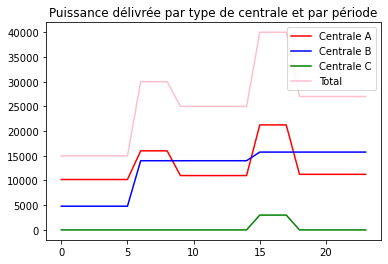

Coûts d'opération : 988540.0 €


In [33]:
Graph_puiss()

*Résultats* :<br>
Nous avons intégré une règle rendant cyclique le fonctionnement de ce système. Le coût total est alors réduis puisque des centrales sont déjà allumées en période 1, il n'y a donc pas besoin de payer un coût de démarrage en début de journée.

## 5 Centrales hydroélectriques

### 5.1 Centrales hydroélectriques

Nouvelles données du problème :<br>
•   HYDRO<sub>h</sub>: type h de centrale hydroélectrique <br>
•   Pfix<sub>h</sub> : Puissance fixe délivrée par chaque type de centrale h <br>
•   cdem<sub>h</sub> : Coût de démarrage de chaque type de centrale h <br>
•   cfonc<sub>h</sub> : Coût de fonctionnement de chaque type de centrale h <br>

Nouvelles variables :<br>
•   Usehydro<sub>h,j</sub> : 1 si on utilise la centrale hydroélectrique de type h à la période j, 0 sinon<br>
•   hydrostart<sub>h,j</sub> : 1 si on a allumé la centrale hydroélectrique de type h à la période j, 0 sinon <br>


Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i} + NBstart_{i,j} * Cstart_{i} + \sum \limits _{p=1} ^{2} \sum \limits _{j=1} ^{24} Usehydro_{h,j} * cfonc_{h} + hydrostart_{h,j} * cdem_{h,j}$$

S.T : 

$$
\left.
    \begin{array}{lcr}
1.   & NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\} \\
2.   & \sum \limits _{i=1} ^{3} Puiss_{i,j} + \sum \limits_{p=1}^{2} Usehydro_{h,j} * pfix_{h} = Dem_{j} & \forall j \in \{1,..,24\}\\
3.   & 0 \le NBcentrale_{i,j}\le nb_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
4.   & NBcentrale_{i,j} - NBcentrale_{i,j-1} \le NBstart_{i,j} &  \forall i \in \{1,2,3\}, \forall j \in \{2,..,24\}\\
5.   & NBcentrale_{i,0} - NBcentrale_{i,24}\le NBstart_{i,0}  &  \forall i \in \{1,2,3\}\\
6.   & \sum \limits_{i=1}^{3} NBcentrale_{i,j} * Pmax_{i} + \sum \limits_{p=1}^{2} (1 - Usehydro_{h,j}) * pfix_{h} \ge Dem_{j} * Reserve  &  \forall j \in \{1,..,24\}\\
7.   & Usehydro_{h,j} - Usehydro_{h,j-1} \le hydrostart_{h,j} &  \forall h \in \{1,2\}, \forall j \in \{2,..,24\}\\
8.   & Usehydro_{h,0} - Usehydro_{h,24}\le hydrostart_{h,0}  &  \forall h \in \{1,2\}\\
     & NBstart_{i,j} \ge 0 &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & Puiss_{i,j} \in \mathbb{R} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & NBcentrale_{i,j}, NBstart_{i,j} \in \mathbb{N} &  \forall i \in \{1,2,3\} , \forall j \in \{1,..,24\}\\
     & Usehydro_{h,j}, hydrostart_{h,j} \in \{0,1\} &  \forall h \in \{1,2\}, \forall j \in \{1,..,24\}\\
    \end{array}
\right.
$$

In [79]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

#Dictionnaire pour stocker les nouvelles données concernant les centrales hydroélectrique
HYDRO, pfix, vab, cdem, cfonc = gp.multidict({
    '1' : [900, 0.31, 1500, 90],
    '2' : [1400, 0.47, 1200, 150],
})

Dem = [15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

#Variable binaire pour l'utilisation d'un centrale de type h à la période j
Usehydro = {(h,j) : Model.addVar(vtype=gp.GRB.BINARY)
                for h in HYDRO for j in range(len(Dem))}

hydrostart = {(h,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

#Ajout des centrales hydroélectriques éteintes dans la puissance potentielle délivrée par le système
POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) + sum((1 - Usehydro[h,j])*pfix[h] for h in HYDRO)
       for j in range(len(Dem))}            

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

#Modification de la contrainte de réponse à la demande en intégrant les centrales hydroélectriques
CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE) + sum(Usehydro[h,j]*pfix[h] for h in HYDRO),"=",Dem[j])
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR_41 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0]- NBcentrale[i,23])
         for i in CENTRALE}

CSTR_31 =  { j : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

#Intérgation des contraintes cycliques pour l'allumage des centrales hydroélectriques
CSTR_511 = {(h) : Model.addLConstr(hydrostart[h,j],">=",Usehydro[h,j] - Usehydro[h,j-1])
             for h in HYDRO for j in range(1,len(Dem))}

CSTR_512 = { h : Model.addLConstr(hydrostart[h,0],">=",Usehydro[h,0] - Usehydro[h,23])
             for h in HYDRO}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
            for i in CENTRALE for j in range(len(Dem))}

Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))) + sum(Usehydro[h,j] * cfonc[h] + hydrostart[h,j]*cdem[h] for h in HYDRO for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [80]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 384 rows, 312 columns and 960 nonzeros
Model fingerprint: 0x747bba31
Variable types: 72 continuous, 240 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [5e+00, 4e+04]
Found heuristic solution: objective 1361030.0000
Presolve removed 72 rows and 0 columns
Presolve time: 0.00s
Presolved: 312 rows, 312 columns, 888 nonzeros
Variable types: 72 continuous, 240 integer (96 binary)
Found heuristic solution: objective 1358380.0000

Root relaxation: objective 8.886975e+05, 90 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 888697.500    0   30 1358380.00 888697.500  34.6% 

In [81]:
def Grap_hydro():
    H1=[]; H2=[]

    for j in range(len(Dem)):        
        H1.append(Usehydro["1",j].x * pfix["1"])
        H2.append(Usehydro["2",j].x * pfix["2"])
        
    ar = [H1, H2]

    df=pd.DataFrame(data=ar, index=["H1", "H2"])

    plt.plot(df.loc["H1"],'magenta', label="Centrale H1")
    plt.plot(df.loc["H2"],'c', label="Centrale H2")
    plt.title('Puissance délivrée par type de centrale hydroélectrique et par période')
    plt.legend()
    plt.ylim(0,1500)
    plt.show()

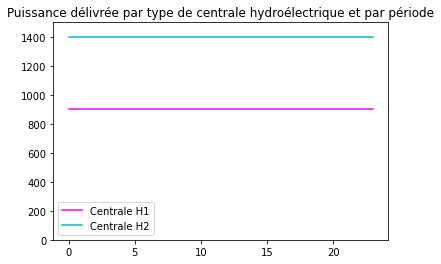

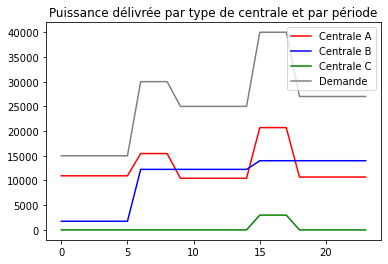

Coûts d'opération : 890510.0 €


In [82]:
Grap_hydro()
Graph_puiss()

*Résultats* :<br>
Dans cette partie, nous intégrons les centrales hydroélectriques. On remarque que ces deux centrales sont peu coûteuses et sont donc utilisées pandant toute la journée en suposant que le réservoir soit infini.

## 5.2 Pompage

Nouvelle donnée du problème :<br>
•   vab<sub>h</sub> : Vitesse d'abaissement du niveau du réservoir par chaque type de centrale h <br>
•   Cpump : Consommation de la pompe pour élever le niveau du réservoir de 1 mètre 



Nouvelle variable :<br>
•   Startpump<sub>j</sub> : le niveau d'eau pompé pendant une période j en mètre


Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i} + NBstart_{i,j} * Cstart_{i} + \sum \limits _{p=1} ^{2} \sum \limits _{j=1} ^{24} Usehydro_{h,j} * cfonc_{h} + hydrostart_{h,j} * cdem_{h,j}$$

S.T : 

$$
\left.
    \begin{array}{lcr}
1.   & NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\} \\
2.   & \sum \limits _{i=1} ^{3} Puiss_{i,j} + \sum \limits_{p=1}^{2} Usehydro_{h,j} * pfix_{h} = Dem_{j} + Startpump_{j} * Cpump & \forall j \in \{1,..,24\}\\
3.   & 0 \le NBcentrale_{i,j}\le nb_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
4.   & NBcentrale_{i,j} - NBcentrale_{i,j-1} \le NBstart_{i,j} &  \forall i \in \{1,2,3\}, \forall j \in \{2,..,24\}\\
5.   & NBcentrale_{i,0} - NBcentrale_{i,24}\le NBstart_{i,0}  &  \forall i \in \{1,2,3\}\\
6.   & \sum \limits_{i=1}^{3} NBcentrale_{i,j} * Pmax_{i} + \sum \limits_{p=1}^{2} (1 - Usehydro_{h,j}) * pfix_{h} \ge Dem_{j} * Reserve  &  \forall j \in \{1,..,24\}\\
7.   & Usehydro_{h,j} - Usehydro_{h,j-1} \le hydrostart_{h,j} &  \forall h \in \{1,2\}, \forall j \in \{2,..,24\}\\
8.   & Usehydro_{h,0} - Usehydro_{h,24}\le hydrostart_{h,0}  &  \forall h \in \{1,2\}\\
9.   & \sum \limits _{j=1} ^{24} Startpump_{j} = \sum \limits _{p=1} ^{2} \sum \limits _{j=1} ^{24} Usehydro_{h,j} * vab_{h} & \\
     & NBstart_{i,j} \ge 0 &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & Puiss_{i,j} \in \mathbb{R} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & Startpump_{j} \in \mathbb{R} &  \forall j \in \{1,..,24\}\\
     & NBcentrale_{i,j}, NBstart_{i,j} \in \mathbb{N} &  \forall i \in \{1,2,3\} , \forall j \in \{1,..,24\}\\
     & Usehydro_{h,j}, hydrostart_{h,j} \in \{0,1\} &  \forall h \in \{1,2\}, \forall j \in \{1,..,24\}\\
    \end{array}
\right.
$$

In [93]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

HYDRO, pfix, vab, cdem, cfonc = gp.multidict({
    '1' : [900, 0.31, 1500, 90],
    '2' : [1400, 0.47, 1200, 150],
})

Dem = [15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15
Cpump = 3000

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

Usehydro = {(h,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

hydrostart = {(h,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

#Ajout de la variable pour la hauteur d'eau pompée par période
Startpump = { j : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0, ub=1)
                for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) + sum((1 - Usehydro[h,j])*pfix[h] for h in HYDRO)
       for j in range(len(Dem))}            

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

#Intégration de la consommation de la pompe dans la puissance à délivrer par le système
CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE) + sum(Usehydro[h,j]*pfix[h] for h in HYDRO),"=",Dem[j] + Startpump[j] * Cpump)
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR_41 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0]- NBcentrale[i,23])
         for i in CENTRALE }

CSTR_31 =  { j : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

CSTR_511 = {(h,j) : Model.addLConstr(hydrostart[h,j],">=",Usehydro[h,j] - Usehydro[h,j-1])
             for h in HYDRO for j in range(1,len(Dem))}

CSTR_512 = { h : Model.addLConstr(hydrostart[h,0],">=",Usehydro[h,0] - Usehydro[h,23])
             for h in HYDRO}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
            for i in CENTRALE for j in range(len(Dem))}

#Calcul de l'abaissement du niveau d'eau du réservoir généré par l'utilisation des centrales hydroélectriques
Conseau = sum(vab[h] * Usehydro[h,j] for h in HYDRO for j in range(len(Dem)))

#Intégration de la contrainte de remise à niveau du réservoir pour chaque journée grâce à l'utilisation de la pompe de relevage
CSTR_52 = {Model.addLConstr(sum(Startpump[j] for j in range(len(Dem))),"=",Conseau)}


Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))) + sum(Usehydro[h,j] * cfonc[h] + hydrostart[h,j]*cdem[h] for h in HYDRO for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [94]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 385 rows, 336 columns and 1056 nonzeros
Model fingerprint: 0xfb18b2a2
Variable types: 168 continuous, 168 integer (96 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [5e+00, 4e+04]
Presolve removed 72 rows and 0 columns
Presolve time: 0.00s
Presolved: 313 rows, 336 columns, 984 nonzeros
Variable types: 96 continuous, 240 integer (96 binary)
Found heuristic solution: objective 1146770.0000
Found heuristic solution: objective 1072390.0000

Root relaxation: objective 9.850143e+05, 154 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 985014.286    0   26 1072390.00 985014.286  8.1

In [95]:

def Graph_pump():
    P=[]

    for j in range(len(Dem)):        
        P.append(Startpump[j].x * 3000)
    ar = [P]
    df=pd.DataFrame(data=ar, index=["P"])
    plt.plot(df.loc["P"],'b')
    plt.title("Niveau d'eau pompé par période")
    plt.show()

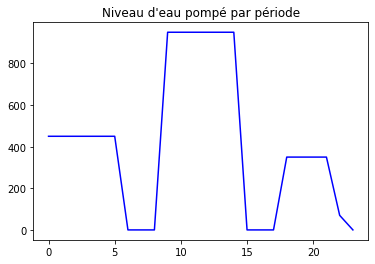

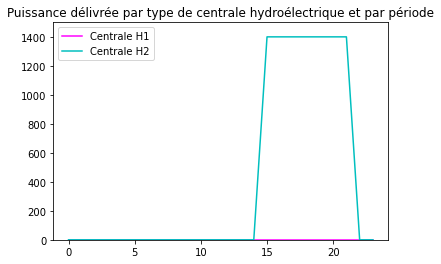

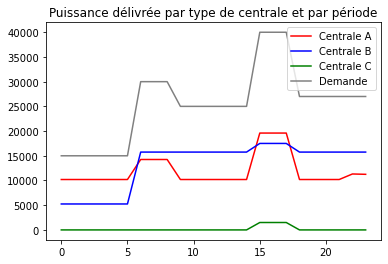

Coûts d'opération : 986540.0 €


In [96]:
Graph_pump()
Grap_hydro()
Graph_puiss()

*Résultats* :<br>
Dans cette partie avons ajouté une station de pompage afin de restituer la quantité d'eau utilisée par les centrales hydroélectriques. On remarque que l'eau est pompée pendant les périodes de creux afin d'être utilisée pendant le pique de la journée. Une centrale éteinte participe à la réserve, c'est pour cela qu'une des deux centrales n'est pas utilisée.

### 5.3 Paliers de fonctionnement

Nouvelles données du problème :<br>
•   Pfix<sub>h,p</sub> : Puissance fixe délivrée par chaque type de centrale h pour chaque palier p<br>
•   vab<sub>h,p</sub> : Vitesse d'abaissement du niveau du réservoir par chaque type de centrale h pour chaque palier p <br>
•   cfonc<sub>h,p</sub> : Coût de fonctionnement de chaque type de centrale h pour chaque palier p<br>

Nouvelles variables :<br>
•   Usehydro<sub>h,p,j</sub> : 1 si on utilise la centrale hydroélectrique de type h au palier p et à la période j, 0 sinon<br>

Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i} + NBstart_{i,j} * Cstart_{i} + \sum \limits _{h=1} ^{2} \sum \limits_{p=1}^{4} \sum \limits _{j=1} ^{24}  Usehydro_{h,p,j} * cfonc_{h,p} + hydrostart_{h,j} * cdem_{h,j}$$

S.T : 

$$
\left.
    \begin{array}{lcr}
1.   & NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\} \\
2.   & \sum \limits _{i=1} ^{3} Puiss_{i,j} + \sum \limits_{h=1}^{2} \sum \limits_{p=1}^{4} Usehydro_{h,p,j} * pfix_{h,p} = Dem_{j} + Startpump_{j} * Cpump & \forall j \in \{1,..,24\}\\
3.   & 0 \le NBcentrale_{i,j}\le nb_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
4.   & NBcentrale_{i,j} - NBcentrale_{i,j-1} \le NBstart_{i,j} &  \forall i \in \{1,2,3\}, \forall j \in \{2,..,24\}\\
5.   & NBcentrale_{i,0} - NBcentrale_{i,24}\le NBstart_{i,0}  &  \forall i \in \{1,2,3\}\\
6.   & \sum \limits_{i=1}^{3} NBcentrale_{i,j} * Pmax_{i} + \sum \limits_{h=1}^{2} (1 - \sum \limits_{p=1}^{4} Usehydro_{h,p,j}) * pfix_{h,4} \ge Dem_{j} * Reserve  &  \forall j \in \{1,..,24\}\\
7.   & \sum \limits_{p=1}^{4} (Usehydro_{h,p,j} - Usehydro_{h,p,j-1}) \le hydrostart_{h,j} &  \forall h \in \{1,2\}, \forall j \in \{2,..,24\}\\
8.   & \sum \limits_{p=1}^{4} (Usehydro_{h,p,0} - Usehydro_{h,p,24})\le hydrostart_{h,0}  &  \forall h \in \{1,2\}\\
9.   & \sum \limits _{j=1} ^{24} Startpump_{j} = \sum \limits _{h=1} ^{2} \sum \limits_{p=1}^{4} \sum \limits _{j=1} ^{24}  Usehydro_{h,p,j} * vab_{h,p} & \\
10.     & \sum \limits_{p=1}^{4} Usehydro_{h,p,j} \le 1 & \forall h \in \{1,2\}, \forall j \in \{2,..,24\}\\
     & NBstart_{i,j} \ge 0 &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & Puiss_{i,j} \in \mathbb{R} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & Startpump_{j} \in \mathbb{R} &  \forall j \in \{1,..,24\}\\
     & NBcentrale_{i,j}, NBstart_{i,j} \in \mathbb{N} &  \forall i \in \{1,2,3\} , \forall j \in \{1,..,24\}\\
     & hydrostart_{h,j} \in \{0,1\} &  \forall h \in \{1,2\}, \forall j \in \{1,..,24\}\\
     & Usehydro_{h,p,j} \in \{0,1\} &  \forall h \in \{1,2\}, \forall p \in \{1,..,4\}, \forall j \in \{1,..,24\}\\
    \end{array}
\right.
$$

In [89]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

#Intégration des nouvelles données pour les différents paliers de fonctionnement des centrales hydroélectriques
HYDRO, pfix, vab, cdem, cfonc = gp.multidict({
    '1' : [gp.tupledict([(0,900), (1,950),(2,1000), (3,1100)]), gp.tupledict([(0,0.31), (1,0.33),(2,0.35), (3,0.38)]), 1500, gp.tupledict([(0,90), (1,95),(2,105), (3,120)])],
    '2' : [gp.tupledict([(0,1400), (1,1500),(2,1600), (3,1700)]),gp.tupledict([(0,0.47), (1,0.50),(2,0.53), (3,0.56)]), 1200, gp.tupledict([(0,150), (1,165),(2,185), (3,210)])],
})

Dem = [15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15
Cpump = 3000

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

#Mise à jour de la variable d'utilisation des centrales hydroélectriques en ajoutant les paliers de fonctionnement
Usehydro = {(h,p,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for p in range(len(pfix[h])) for j in range(len(Dem))}

hydrostart = {(h,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

Startpump = { j : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0, ub=1)
                for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

#MAJ avec les paliers
POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) + sum((1-sum(Usehydro[h,p,j] for p in vab['1']))*pfix[h][3] for h in HYDRO)
       for j in range(len(Dem))}            

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

#MAJ aved les paliers
CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE) + sum(Usehydro[h,p,j]*pfix[h][p] for h in HYDRO for p in vab[h]),"=",Dem[j] + Startpump[j] * Cpump)
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR_41 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0]- NBcentrale[i,23])
         for i in CENTRALE }

CSTR_31 =  { j : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

#MAJ avec les paliers
CSTR_511 = {(h,j) : Model.addLConstr(hydrostart[h,j],">=",sum(Usehydro[h,p,j] - Usehydro[h,p,j-1] for p in vab[h]))
             for h in HYDRO for j in range(1,len(Dem))}

#MAJ avec les paliers
CSTR_512 = { h : Model.addLConstr(hydrostart[h,0],">=",sum(Usehydro[h,p,0] - Usehydro[h,p,23] for p in vab[h]))
             for h in HYDRO}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
       for i in CENTRALE for j in range(len(Dem))}

#MAJ avec les paliers
Conseau = sum(vab[h][p] * Usehydro[h,p,j] for h in HYDRO for p in vab[h] for j in range(len(Dem)))

CSTR_52 = {Model.addLConstr(sum(Startpump[j] for j in range(len(Dem))),"=",Conseau)}

#Intégration de la contrainte d'utilisation d'un seul palier de centrale hydroélectrique par période et par centrale
CSTR_53 = {(h,j) : Model.addLConstr(sum(Usehydro[h,p,j] for p in vab[h]),"<=",1)
          for h in HYDRO for j in range(len(Dem))}                                   

#MAJ avec les paliers                                
Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))) + sum(Usehydro[h,p,j] * cfonc[h][p] for h in HYDRO for p in vab[h] for j in range(len(Dem))) + sum(hydrostart[h,j]*cdem[h] for h in HYDRO for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [90]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 433 rows, 480 columns and 1968 nonzeros
Model fingerprint: 0xccc4b3b3
Variable types: 168 continuous, 312 integer (240 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 4e+04]
Presolve removed 72 rows and 0 columns
Presolve time: 0.00s
Presolved: 361 rows, 480 columns, 1896 nonzeros
Variable types: 96 continuous, 384 integer (240 binary)
Found heuristic solution: objective 1146770.0000
Found heuristic solution: objective 1086990.0000

Root relaxation: objective 9.850143e+05, 186 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 985014.286    0   26 1086990.00 985014.286  

In [91]:
def Graph_palier():
    HDS1=[]; HDS2=[]

    for j in range(24):
        HDS1.append(sum(pfix["1"][p]*Usehydro["1",p,j].x for p in vab["1"]))
        HDS2.append(sum(pfix["2"][p]*Usehydro["2",p,j].x for p in vab["2"]))
        
    ar = [HDS1, HDS2]

    df=pd.DataFrame(data=ar, index=["HDS1", "HDS2"])

    plt.plot(df.loc["HDS1"],'magenta', label="Centrale H1")
    plt.plot(df.loc["HDS2"],'Cyan', label="Centrale H2")
    plt.title("Puissance délivrée par les centrales hydroélectriques")
    plt.legend()
    plt.show()


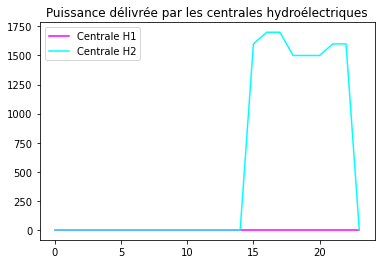

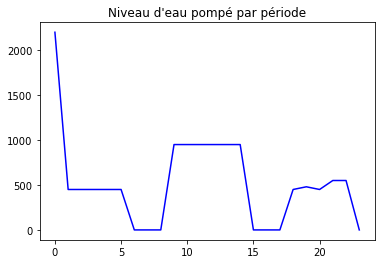

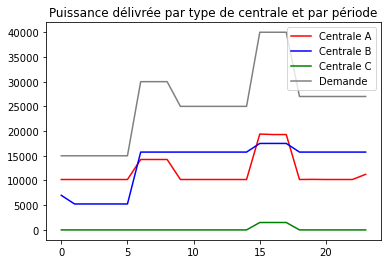

Coûts d'opération : 986430.0 €


In [92]:
Graph_palier()
Graph_pump()
Graph_puiss()

*Résultats* :<br>
Dans cette partie avons ajouté des paliers de fonctionnement aux centrales hydroélectriques, on remarque alors qu'en fonction de la demande la centrale "H2" fait variée sa puissance délivrée.

### 5.4 Exclusion pompage et génération hydro

Modèle mathématique :<br>

Obj : $$Min \sum \limits _{i=1} ^{3} \sum \limits _{j=1} ^{24} NBcentrale_{i,j} * Cbase_{i} + (Puiss_{i,j} - NBcentrale_{i,j} * Pmin_{i}) * Cmwh_{i} + NBstart_{i,j} * Cstart_{i} + \sum \limits _{h=1} ^{2} \sum \limits_{p=1}^{4} \sum \limits _{j=1} ^{24}  Usehydro_{h,p,j} * cfonc_{h,p} + hydrostart_{h,j} * cdem_{h,j}$$

S.T : 

$$
\left.
    \begin{array}{lcr}
1.   & NBcentrale_{i,j} * Pmin_{i} \le Puiss_{i,j} \le NBcentrale_{i,j} * Pmax_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\} \\
2.   & \sum \limits _{i=1} ^{3} Puiss_{i,j} + \sum \limits_{h=1}^{2} \sum \limits_{p=1}^{4} Usehydro_{h,p,j} * pfix_{h,p} = Dem_{j} + Startpump_{j} * Cpump & \forall j \in \{1,..,24\}\\
3.   & 0 \le NBcentrale_{i,j}\le nb_{i} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
4.   & NBcentrale_{i,j} - NBcentrale_{i,j-1} \le NBstart_{i,j} &  \forall i \in \{1,2,3\}, \forall j \in \{2,..,24\}\\
5.   & NBcentrale_{i,0} - NBcentrale_{i,24}\le NBstart_{i,0}  &  \forall i \in \{1,2,3\}\\
6.   & \sum \limits_{i=1}^{3} NBcentrale_{i,j} * Pmax_{i} + \sum \limits_{h=1}^{2} (1 - \sum \limits_{p=1}^{4} Usehydro_{h,p,j}) * pfix_{h,4} \ge Dem_{j} * Reserve  &  \forall j \in \{1,..,24\}\\
7.   & \sum \limits_{p=1}^{4} (Usehydro_{h,p,j} - Usehydro_{h,p,j-1}) \le hydrostart_{h,j} &  \forall h \in \{1,2\}, \forall j \in \{2,..,24\}\\
8.   & \sum \limits_{p=1}^{4} (Usehydro_{h,p,0} - Usehydro_{h,p,24})\le hydrostart_{h,0}  &  \forall h \in \{1,2\}\\
9.   & \sum \limits _{j=1} ^{24} Startpump_{j} = \sum \limits _{h=1} ^{2} \sum \limits_{p=1}^{4} \sum \limits _{j=1} ^{24}  Usehydro_{h,p,j} * vab_{h,p} & \\
10.  & \sum \limits_{p=1}^{4} Usehydro_{h,p,j} \le 1 & \forall h \in \{1,2\}, \forall j \in \{2,..,24\}\\
11.  & Startpump_{j} \le 1 - \sum \limits_{p=1}^{4} Usehydro_{1,p,j} & \forall j \in \{2,..,24\}\\
12.  & Startpump_{j} \le 1 - \sum \limits_{p=1}^{4} Usehydro_{2,p,j} & \forall j \in \{2,..,24\}\\
     & NBstart_{i,j} \ge 0 &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & Puiss_{i,j} \in \mathbb{R} &  \forall i \in \{1,2,3\}, \forall j \in \{1,..,24\}\\
     & Startpump_{j} \in \mathbb{R} &  \forall j \in \{1,..,24\}\\
     & NBcentrale_{i,j}, NBstart_{i,j} \in \mathbb{N} &  \forall i \in \{1,2,3\} , \forall j \in \{1,..,24\}\\
     & hydrostart_{h,j} \in \{0,1\} &  \forall h \in \{1,2\}, \forall j \in \{1,..,24\}\\
     & Usehydro_{h,p,j} \in \{0,1\} &  \forall h \in \{1,2\}, \forall p \in \{1,..,4\}, \forall j \in \{1,..,24\}\\
    \end{array}
\right.
$$

In [83]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

HYDRO, pfix, vab, cdem, cfonc = gp.multidict({
    '1' : [gp.tupledict([(0,900), (1,950),(2,1000), (3,1100)]), gp.tupledict([(0,0.31), (1,0.33),(2,0.35), (3,0.38)]), 1500, gp.tupledict([(0,90), (1,95),(2,105), (3,120)])],
    '2' : [gp.tupledict([(0,1400), (1,1500),(2,1600), (3,1700)]),gp.tupledict([(0,0.47), (1,0.50),(2,0.53), (3,0.56)]), 1200, gp.tupledict([(0,150), (1,165),(2,185), (3,210)])],
})

Dem = [15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem))}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

Usehydro = {(h,p,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for p in range(len(pfix['1'])) for j in range(len(Dem))}

hydrostart = {(h,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

Startpump = { j : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0, ub=1)
                for j in range(len(Dem))}

DISPOMIN = {(i,j): NBcentrale[i,j]*Pmin[i] 
            for i in CENTRALE for j in range(len(Dem))}

DISPOMAX = {(i,j): NBcentrale[i,j]*Pmax[i] 
            for i in CENTRALE for j in range(len(Dem))}

POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) + sum((1-sum(Usehydro[h,p,j] for p in vab['1']))*pfix[h][3] for h in HYDRO)
       for j in range(len(Dem))}            

CSTR1 = { (i,j) : Model.addLConstr(DISPOMIN[i,j], "<=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR2 = { (i,j) : Model.addLConstr(DISPOMAX[i,j], ">=" ,Puiss[i,j])
         for i in CENTRALE for j in range(len(Dem))}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j] for i in CENTRALE) + sum(Usehydro[h,p,j]*pfix[h][p] for h in HYDRO for p in vab[h]),"=",Dem[j] + Startpump[j] * 3000)
         for j in range(len(Dem))}

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR_41 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0]- NBcentrale[i,23])
         for i in CENTRALE }

CSTR_31 =  { j : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

CSTR_511 = {(h,j) : Model.addLConstr(hydrostart[h,j],">=",sum(Usehydro[h,p,j] - Usehydro[h,p,j-1] for p in vab[h]))
             for h in HYDRO for j in range(1,len(Dem))}

CSTR_512 = { h : Model.addLConstr(hydrostart[h,0],">=",sum(Usehydro[h,p,0] - Usehydro[h,p,23] for p in vab[h]))
             for h in HYDRO}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (Puiss[i,j] - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
       for i in CENTRALE for j in range(len(Dem))}

Conseau = sum(vab[h][p] * Usehydro[h,p,j] for h in HYDRO for p in vab[h] for j in range(len(Dem)))

CSTR_52 = {Model.addLConstr(sum(Startpump[j] for j in range(len(Dem))),"=",Conseau)}

CSTR_53 = {(h,j) : Model.addLConstr(sum(Usehydro[h,p,j] for p in vab[h]),"<=",1)
          for h in HYDRO for j in range(len(Dem))}

#Ajout des contraintes d'exclusion du pompage pendant la génération de puissance hydroélectrique
CSTR_54 = { j : Model.addLConstr(Startpump[j],"<=",1-sum(Usehydro['2',p,j] for p in vab['2']))
          for j in range(len(Dem))}

CSTR_54 = { j : Model.addLConstr(Startpump[j],"<=",1-sum(Usehydro['1',p,j] for p in vab['1']))
          for j in range(len(Dem))}
                                  
Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))) + sum(Usehydro[h,p,j] * cfonc[h][p] for h in HYDRO for p in vab[h] for j in range(len(Dem))) + sum(hydrostart[h,j]*cdem[h] for h in HYDRO for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [84]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 481 rows, 480 columns and 2208 nonzeros
Model fingerprint: 0x6d6b482a
Variable types: 168 continuous, 312 integer (240 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 4e+04]
Presolve removed 120 rows and 0 columns
Presolve time: 0.01s
Presolved: 361 rows, 480 columns, 1944 nonzeros
Variable types: 96 continuous, 384 integer (240 binary)
Found heuristic solution: objective 1146770.0000
Found heuristic solution: objective 1086990.0000

Root relaxation: objective 9.850143e+05, 173 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 985014.286    0   26 1086990.00 985014.286 

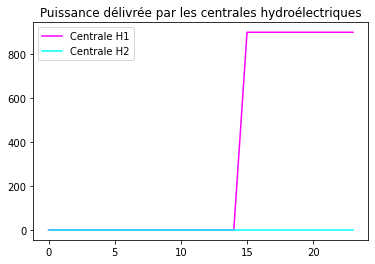

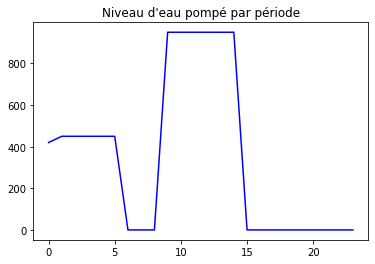

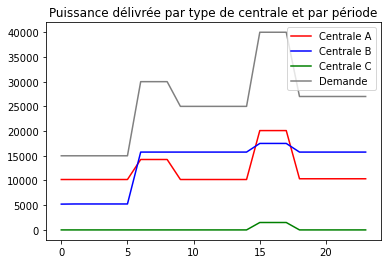

Coûts d'opération : 987021.0 €


In [87]:
Graph_palier()
Graph_pump()
Graph_puiss()

*Résultats* :<br>
Dans cette partie avons ajouté une règle pour la gestion de la station de pompage : la pompe ne peux pas fonctionner en même temps qu'une centrale hydroélectrique. On remarque bien cette exclusion sur les deux premiers graphiques.

## 6 Désagrégation

### 6.1 Individualisation des centrales

In [139]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

HYDRO, pfix, vab, cdem, cfonc = gp.multidict({
    '1' : [gp.tupledict([(0,900), (1,950),(2,1000), (3,1100)]), gp.tupledict([(0,0.31), (1,0.33),(2,0.35), (3,0.38)]), 1500, gp.tupledict([(0,90), (1,95),(2,105), (3,120)])],
    '2' : [gp.tupledict([(0,1400), (1,1500),(2,1600), (3,1700)]),gp.tupledict([(0,0.47), (1,0.50),(2,0.53), (3,0.56)]), 1200, gp.tupledict([(0,150), (1,165),(2,185), (3,210)])],
})

Dem = [15, 15, 15, 15, 15, 15, 30 , 30 , 30, 25, 25, 25, 25, 25, 25, 40, 40, 40, 27, 27, 27, 27, 27, 27]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j,k) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem)) for k in range(nb[i])}

Use = {(i,j,k) : Model.addVar(vtype=gp.GRB.BINARY)
                for i in CENTRALE for j in range(len(Dem)) for k in range(nb[i])}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

Usehydro = {(h,p,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for p in range(len(pfix['1'])) for j in range(len(Dem))}

hydrostart = {(h,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

Startpump = { j : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0, ub=1)
                for j in range(len(Dem))}

POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) + sum((1-sum(Usehydro[h,p,j] for p in vab['1']))*pfix[h][3] for h in HYDRO)
       for j in range(len(Dem))}            

CSTR1 = { (i,j,k) : Model.addLConstr(Pmin[i] * Use[i,j,k] , "<=" ,Puiss[i,j,k])
         for i in CENTRALE for j in range(len(Dem)) for k in range(nb[i])}

CSTR2 = { (i,j,k) : Model.addLConstr(Pmax[i] * Use[i,j,k], ">=" ,Puiss[i,j,k])
         for i in CENTRALE for j in range(len(Dem)) for k in range(nb[i])}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j,k] for i in CENTRALE for k in range(nb[i])) + sum(Usehydro[h,p,j]*pfix[h][p] for h in HYDRO for p in vab[h]),"=",Dem[j] + Startpump[j] * 3000)
         for j in range(len(Dem))}
         

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR_41 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0]- NBcentrale[i,23])
         for i in CENTRALE }

CSTR_31 =  { j : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

CSTR_511 = {(h,j) : Model.addLConstr(hydrostart[h,j],">=",sum(Usehydro[h,p,j] - Usehydro[h,p,j-1] for p in vab[h]))
             for h in HYDRO for j in range(1,len(Dem))}

CSTR_512 = { h : Model.addLConstr(hydrostart[h,0],">=",sum(Usehydro[h,p,0] - Usehydro[h,p,23] for p in vab[h]))
             for h in HYDRO}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (sum(Puiss[i,j,k] for k in range(nb[i])) - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
       for i in CENTRALE for j in range(len(Dem))}

Conseau = sum(vab[h][p] * Usehydro[h,p,j] for h in HYDRO for p in vab[h] for j in range(len(Dem)))

CSTR_52 = {Model.addLConstr(sum(Startpump[j] for j in range(len(Dem))),"=",Conseau)}

CSTR_53 = {(h,j) : Model.addLConstr(sum(Usehydro[h,p,j] for p in vab[h]),"<=",1)
          for h in HYDRO for j in range(len(Dem))}

CSTR_54 = { j : Model.addLConstr(Startpump[j],"<=",1-sum(Usehydro['2',p,j] for p in vab['2']))
          for j in range(len(Dem))}

CSTR_54 = { j : Model.addLConstr(Startpump[j],"<=",1-sum(Usehydro['1',p,j] for p in vab['1']))
          for j in range(len(Dem))}

CSTR_611 = { (i,j) : Model.addLConstr(sum(Use[i,j,k] for k in range(nb[i])),"=",NBcentrale[i,j])
          for i in CENTRALE for j in range(len(Dem))}



                                  
Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))) + sum(Usehydro[h,p,j] * cfonc[h][p] for h in HYDRO for p in vab[h] for j in range(len(Dem))) + sum(hydrostart[h,j]*cdem[h] for h in HYDRO for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [140]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1705 rows, 1704 columns and 5808 nonzeros
Model fingerprint: 0xe507df96
Variable types: 744 continuous, 960 integer (888 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 4e+04]
Presolve removed 120 rows and 0 columns
Presolve time: 0.02s
Presolved: 1585 rows, 1704 columns, 5544 nonzeros
Variable types: 672 continuous, 1032 integer (888 binary)
Found heuristic solution: objective 1241900.0000
Found heuristic solution: objective 1041700.0000

Root relaxation: objective 9.850143e+05, 1473 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 985014.286    0   50 1041700.00 9850

In [144]:
for j in range(24): 
    for k in range(nb["A"]):
        print(Puiss["A",j,k].x)
          
        

850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
2000.0
2000.0
1450.0
2000.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
2000.0
2000.0
1450.0
2000.0
850.0
850.0
850.0
850.0
850.0
850.0
2000.0
2000.0
2000.0
1450.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.0
850.

### 6.2 Planification au pas horraire

Déjà le cas

### 6.3 Précision du profil de demande

In [145]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

HYDRO, pfix, vab, cdem, cfonc = gp.multidict({
    '1' : [gp.tupledict([(0,900), (1,950),(2,1000), (3,1100)]), gp.tupledict([(0,0.31), (1,0.33),(2,0.35), (3,0.38)]), 1500, gp.tupledict([(0,90), (1,95),(2,105), (3,120)])],
    '2' : [gp.tupledict([(0,1400), (1,1500),(2,1600), (3,1700)]),gp.tupledict([(0,0.47), (1,0.50),(2,0.53), (3,0.56)]), 1200, gp.tupledict([(0,150), (1,165),(2,185), (3,210)])],
})

Dem = [17, 15, 14, 13, 13, 18, 29 , 32, 29, 27, 25, 25, 24, 24, 25, 38, 42, 40, 33, 31, 27, 26, 24, 21]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j,k) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem)) for k in range(nb[i])}

Use = {(i,j,k) : Model.addVar(vtype=gp.GRB.BINARY)
                for i in CENTRALE for j in range(len(Dem)) for k in range(nb[i])}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

Usehydro = {(h,p,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for p in range(len(pfix['1'])) for j in range(len(Dem))}

hydrostart = {(h,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

Startpump = { j : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0, ub=1)
                for j in range(len(Dem))}

POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) + sum((1-sum(Usehydro[h,p,j] for p in vab['1']))*pfix[h][3] for h in HYDRO)
       for j in range(len(Dem))}            

CSTR1 = { (i,j,k) : Model.addLConstr(Pmin[i] * Use[i,j,k] , "<=" ,Puiss[i,j,k])
         for i in CENTRALE for j in range(len(Dem)) for k in range(nb[i])}

CSTR2 = { (i,j,k) : Model.addLConstr(Pmax[i] * Use[i,j,k], ">=" ,Puiss[i,j,k])
         for i in CENTRALE for j in range(len(Dem)) for k in range(nb[i])}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j,k] for i in CENTRALE for k in range(nb[i])) + sum(Usehydro[h,p,j]*pfix[h][p] for h in HYDRO for p in vab[h]),"=",Dem[j] + Startpump[j] * 3000)
         for j in range(len(Dem))}
         

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR_41 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0]- NBcentrale[i,23])
         for i in CENTRALE }

CSTR_31 =  { j : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

CSTR_511 = {(h,j) : Model.addLConstr(hydrostart[h,j],">=",sum(Usehydro[h,p,j] - Usehydro[h,p,j-1] for p in vab[h]))
             for h in HYDRO for j in range(1,len(Dem))}

CSTR_512 = { h : Model.addLConstr(hydrostart[h,0],">=",sum(Usehydro[h,p,0] - Usehydro[h,p,23] for p in vab[h]))
             for h in HYDRO}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (sum(Puiss[i,j,k] for k in range(nb[i])) - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
       for i in CENTRALE for j in range(len(Dem))}

Conseau = sum(vab[h][p] * Usehydro[h,p,j] for h in HYDRO for p in vab[h] for j in range(len(Dem)))

CSTR_52 = {Model.addLConstr(sum(Startpump[j] for j in range(len(Dem))),"=",Conseau)}

CSTR_53 = {(h,j) : Model.addLConstr(sum(Usehydro[h,p,j] for p in vab[h]),"<=",1)
          for h in HYDRO for j in range(len(Dem))}

CSTR_54 = { j : Model.addLConstr(Startpump[j],"<=",1-sum(Usehydro['2',p,j] for p in vab['2']))
          for j in range(len(Dem))}

CSTR_54 = { j : Model.addLConstr(Startpump[j],"<=",1-sum(Usehydro['1',p,j] for p in vab['1']))
          for j in range(len(Dem))}

CSTR_611 = { (i,j) : Model.addLConstr(sum(Use[i,j,k] for k in range(nb[i])),"=",NBcentrale[i,j])
          for i in CENTRALE for j in range(len(Dem))}



                                  
Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))) + sum(Usehydro[h,p,j] * cfonc[h][p] for h in HYDRO for p in vab[h] for j in range(len(Dem))) + sum(hydrostart[h,j]*cdem[h] for h in HYDRO for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [146]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1705 rows, 1704 columns and 5808 nonzeros
Model fingerprint: 0x58424118
Variable types: 744 continuous, 960 integer (888 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 5e+04]
Presolve removed 120 rows and 0 columns
Presolve time: 0.02s
Presolved: 1585 rows, 1704 columns, 5544 nonzeros
Variable types: 672 continuous, 1032 integer (888 binary)
Found heuristic solution: objective 1244800.0000
Found heuristic solution: objective 1047850.0000

Root relaxation: objective 9.872107e+05, 1434 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 987210.669    0   65 1047850.00 9872

### 6.4 Discrétisation à un pas de 2 heures

In [147]:
import gurobipy as gp

CENTRALE, nb, Pmin, Pmax, Cstart, Cbase, Cmwh  = gp.multidict({
    'A' : [12, 850, 2000, 2000, 1000, 2.0],
    'B' : [10, 1250, 1750, 1000, 2600, 1.3],
    'C' : [5, 1500, 4000, 500, 3000, 3],
})

HYDRO, pfix, vab, cdem, cfonc = gp.multidict({
    '1' : [gp.tupledict([(0,900), (1,950),(2,1000), (3,1100)]), gp.tupledict([(0,0.31), (1,0.33),(2,0.35), (3,0.38)]), 1500, gp.tupledict([(0,90), (1,95),(2,105), (3,120)])],
    '2' : [gp.tupledict([(0,1400), (1,1500),(2,1600), (3,1700)]),gp.tupledict([(0,0.47), (1,0.50),(2,0.53), (3,0.56)]), 1200, gp.tupledict([(0,150), (1,165),(2,185), (3,210)])],
})

Dem = [16, 16, 14, 14, 16, 16, 30 , 30, 28, 28, 25, 25, 24, 24, 33, 33, 41, 41, 32, 32, 26, 26, 22, 22]

for i in range(len(Dem)):
    Dem[i]=Dem[i]*10**3
    
Reserve = 1.15

Model = gp.Model(name = 'Centrales thermiques2')

NBcentrale = {(i,j) : Model.addVar(vtype=gp.GRB.INTEGER,
                                  lb=0,  ub=nb[i])                             
              for i in CENTRALE for j in range(len(Dem))}

Puiss = {(i,j,k) : Model.addVar(vtype=gp.GRB.CONTINUOUS)
                for i in CENTRALE for j in range(len(Dem)) for k in range(nb[i])}

Use = {(i,j,k) : Model.addVar(vtype=gp.GRB.BINARY)
                for i in CENTRALE for j in range(len(Dem)) for k in range(nb[i])}

NBstart = {(i,j) : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0)
                for i in CENTRALE for j in range(len(Dem))}

Usehydro = {(h,p,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for p in range(len(pfix['1'])) for j in range(len(Dem))}

hydrostart = {(h,j) : Model.addVar(vtype=gp.GRB.BINARY,
                               lb=0, ub=1)
                for h in HYDRO for j in range(len(Dem))}

Startpump = { j : Model.addVar(vtype=gp.GRB.CONTINUOUS,
                               lb=0, ub=1)
                for j in range(len(Dem))}

POT = {j: sum(NBcentrale[i,j]*Pmax[i] for i in CENTRALE) + sum((1-sum(Usehydro[h,p,j] for p in vab['1']))*pfix[h][3] for h in HYDRO)
       for j in range(len(Dem))}            

CSTR1 = { (i,j,k) : Model.addLConstr(Pmin[i] * Use[i,j,k] , "<=" ,Puiss[i,j,k])
         for i in CENTRALE for j in range(len(Dem)) for k in range(nb[i])}

CSTR2 = { (i,j,k) : Model.addLConstr(Pmax[i] * Use[i,j,k], ">=" ,Puiss[i,j,k])
         for i in CENTRALE for j in range(len(Dem)) for k in range(nb[i])}

CSTR3 = { j : Model.addLConstr(sum(Puiss[i,j,k] for i in CENTRALE for k in range(nb[i])) + sum(Usehydro[h,p,j]*pfix[h][p] for h in HYDRO for p in vab[h]),"=",Dem[j] + Startpump[j] * 3000)
         for j in range(len(Dem))}
         

CSTR4 =  { (i,j) : Model.addLConstr(NBcentrale[i,j],"<=",nb[i])
         for i in CENTRALE for j in range(len(Dem))}

CSTR5 =  { (i,j) : Model.addLConstr(NBstart[i,j],">=",NBcentrale[i,j]-NBcentrale[i,j-1])
         for i in CENTRALE for j in range(1,len(Dem))}

CSTR_41 =  { (i) : Model.addLConstr(NBstart[i,0],">=",NBcentrale[i,0]- NBcentrale[i,23])
         for i in CENTRALE }

CSTR_31 =  { j : Model.addLConstr(POT[j],">=",Dem[j]*Reserve)
             for j in range(len(Dem))}

CSTR_511 = {(h,j) : Model.addLConstr(hydrostart[h,j],">=",sum(Usehydro[h,p,j] - Usehydro[h,p,j-1] for p in vab[h]))
             for h in HYDRO for j in range(1,len(Dem))}

CSTR_512 = { h : Model.addLConstr(hydrostart[h,0],">=",sum(Usehydro[h,p,0] - Usehydro[h,p,23] for p in vab[h]))
             for h in HYDRO}

Cnew = {(i,j): NBcentrale[i,j]*Cbase[i] + (sum(Puiss[i,j,k] for k in range(nb[i])) - NBcentrale[i,j] * Pmin[i]) * Cmwh[i] 
       for i in CENTRALE for j in range(len(Dem))}

Conseau = sum(vab[h][p] * Usehydro[h,p,j] for h in HYDRO for p in vab[h] for j in range(len(Dem)))

CSTR_52 = {Model.addLConstr(sum(Startpump[j] for j in range(len(Dem))),"=",Conseau)}

CSTR_53 = {(h,j) : Model.addLConstr(sum(Usehydro[h,p,j] for p in vab[h]),"<=",1)
          for h in HYDRO for j in range(len(Dem))}

CSTR_54 = { j : Model.addLConstr(Startpump[j],"<=",1-sum(Usehydro['2',p,j] for p in vab['2']))
          for j in range(len(Dem))}

CSTR_54 = { j : Model.addLConstr(Startpump[j],"<=",1-sum(Usehydro['1',p,j] for p in vab['1']))
          for j in range(len(Dem))}

CSTR_611 = { (i,j) : Model.addLConstr(sum(Use[i,j,k] for k in range(nb[i])),"=",NBcentrale[i,j])
          for i in CENTRALE for j in range(len(Dem))}



                                  
Model.setObjective(sum(Cnew[i,j] + NBstart[i,j] * Cstart[i]  for i in CENTRALE for j in range(len(Dem))) + sum(Usehydro[h,p,j] * cfonc[h][p] for h in HYDRO for p in vab[h] for j in range(len(Dem))) + sum(hydrostart[h,j]*cdem[h] for h in HYDRO for j in range(len(Dem))),gp.GRB.MINIMIZE)

In [148]:
Model.update()
Model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1705 rows, 1704 columns and 5808 nonzeros
Model fingerprint: 0xe4209196
Variable types: 744 continuous, 960 integer (888 binary)
Coefficient statistics:
  Matrix range     [3e-01, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 4e+04]
Presolve removed 120 rows and 0 columns
Presolve time: 0.03s
Presolved: 1585 rows, 1704 columns, 5544 nonzeros
Variable types: 672 continuous, 1032 integer (888 binary)
Found heuristic solution: objective 1242400.0000
Found heuristic solution: objective 1050600.0000

Root relaxation: objective 9.897719e+05, 1480 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 989771.867    0   49 1050600.00 9897